In [197]:
#Needed to go through json
import pandas as pd
from pandas import Series, DataFrame, Panel
import urlparse
import numpy as np
import matplotlib.pyplot as plt
import requests
import requests_ftp
import requests_cache
import urllib2
from bs4 import BeautifulSoup
import re


#Needed to scrape ONI index
import re
import itertools

#Graphing tools
%matplotlib inline
%pylab inline
plt.rcParams['figure.figsize'] = (10, 10)

#Text Searching and Pathway Finding
import urllib2
import csv
import os
import string

#Graphing
from numpy import nan
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import seaborn as sns

#SQL
from sqlalchemy import create_engine

#Cache
requests_cache.install_cache('Final_Project')

Populating the interactive namespace from numpy and matplotlib


<h3>Data Part 1: Use NOAA Climate Web API to Gather Precip, Temp Avg, Temp Min, and Temp max for all available months for selected domestic staitons.</h3>

In [150]:
key = "oKEFxtWBGJZobSCrwRmtcWzyXHRSJgNR"
base_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

def grab_data(station, Param, year):
    """
    Input: Station ID (str), Param (str), and year (int)
    Output: List of json objects for the given param in a given year
    """
    #Initialize the json object
    json_int = []
    
    #Send the request with the appropriate parementers
    response = requests.get(base_url, params = {
            "datasetid" : "GSOM", #Global Summary of the month
            "stationid" : station, #Station of interest
            "datatypeid" : Param, #Parameter of interest
            "units" : "standard", #Get readable units
            "startdate": str(year)+ "-01-01", #Start year in Jan
            "enddate" : str(year)+ "-12-31", #End year in Dec
            "limit" : 1000 #Get max amount of tokens
        }, headers = {"token":key});
    response.raise_for_status() # check for errors
    
    #Try to turn the above into a json. If there is no json object return void meaning to void the list later on.
    try:
        end = response.json()['results']
    except:
        end = "void"
    return end

In [151]:
#List of values of interest (temperature min, temperature max, temperature avg, and precipation)
Param =["TMIN", "TMAX", "TAVG", "PRCP"]

def cols_of_int(station, Param, Year_start, Year_end):
    """
    Input: Station of interest (str), parameter of interest(str), year start(int), and year end(int).
    Output: List of dictionaries with the date and the value of interest.
    """
    data = [] #intialize the dataframe
    
    #Loop over years to grab all years of interest in the relevant range
    for year in range(Year_start,Year_end+1):
        json_int = grab_data(station, Param, year) #Run the function listed above to grab the json object

        #If there is information run the following code:
        if json_int != "void":
            
            #Create a dictionary containing date and parameter value.
            for day in json_int:
                data_int = {"Date":"", Param:""}
                data_int[Param] = str(day["value"])
                data_int["Date"] = str(day["date"]).split("T")[0]            
                data.append(data_int)
    return data

In [152]:
def data_frame_creation(station,location,year_start,year_end):
    """
    Input: station (str), location (str), start year to collect data (int), and end year to collect data (int).
    Output: Dataframe containing all of the parameters of interest for a station.
    """
    T_min, T_max, T_avg, Precip = [cols_of_int(station,measure,year_start,year_end) for measure in Param] #Runs the previous function for all of the diferent parameters.
    Values = [T_min, T_max, T_avg, Precip] #Creates a list of all of the information
    
    Int_df = pd.DataFrame(T_min) #Sets up the dataframe using the first value
    
    #Loop going through the remaining parameters and adding the columns to the dataframe joined based on date. If no date supposed to return NA.
    for measures in Values[1:]:
        df = pd.DataFrame(measures)
        Int_df = pd.merge(Int_df, df, how='outer', on='Date')
        Int_df["station"] = station #Add the station information
        Int_df["location"] = location #Add the station information
    return Int_df

In [153]:
#Location of all the domestic station id's and locations of interest
domestic_station_ids = [['GHCND:USW00023271','Sacramento, CA'],['GHCND:USW00022521','Honolulu, HI'],['GHCND:USW00024233','Seattle, WA'],['GHCND:USW00012839','Miami, FL'],['GHCND:USW00023174','Los Angeles, CA'],['GHCND:USW00014733','Buffalo, NY'],['GHCND:USW00093037','Colorado Springs, CO'],['GHCND:USW00013988','Kansas City, MO'],['GHCND:USW00024229','Portland, OR'],['GHCND:USC00111577','Chicago, IL'],['GHCND:USW00012930','New Orleans, LA'],['GHCND:USW00014922','Minneapolis, MN'],['GHCND:USW00025309','Juneau, AK'],['GHCND:USW00013897','Nashville, TN'],['GHCND:USC00186350','Washington D.C.'],['GHCND:USW00014606','Bangor, ME']]

In [154]:
#This is the code that takes in all the stations of interest and goes throught he 3 functions above.
#THIS CODE TAKES ABOUT 30 min to run!!!!
list_data = []
for x in domestic_station_ids:
    list_data.append(data_frame_creation(x[0],x[1],1950,2016))

In [155]:
#Combine the seperate dataframes in the list into a signle dataframe. Ignored index for easier use later on.
final_df = pd.concat(list_data, ignore_index=True)

#This code adds the month and year on to the data frame
final_df['Month'] = [month.split("-")[1] for month in final_df['Date']]
final_df['Year'] = [year.split("-")[0] for year in final_df['Date']]
final_df["Date"] = final_df["Year"]+"-"+final_df["Month"]

In [159]:
#This is the df before the ONI index
final_df.head()

,Date,TMIN,TMAX,station,location,TAVG,PRCP,Month,Year
0,1950-01,36.6,50.4,GHCND:USW00023271,"Sacramento, CA",43.5,4.41,01,1950
1,1950-02,41.8,61.3,GHCND:USW00023271,"Sacramento, CA",51.6,3.27,02,1950
2,1950-03,43.5,63.6,GHCND:USW00023271,"Sacramento, CA",53.5,2.0,03,1950
3,1950-04,49.3,74.6,GHCND:USW00023271,"Sacramento, CA",62.0,1.04,04,1950
4,1950-05,51.1,80.5,GHCND:USW00023271,"Sacramento, CA",65.8,0.37,05,1950


<h3>Data Part 2: Extract data for the ONI index Using Web Scraping Techniques</h3>

In [160]:
#This section scrapes the ONI index page
url = "http://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ensoyears.shtml"
ONI_req = requests.get(url) #Ping the server
ONI_html = ONI_req.text #Obtain the text file of the webstie
ONI = BeautifulSoup(ONI_html, 'lxml') #Change to html code
ONI_data = ONI.findAll('table',{'border':"1"})[0]

In [161]:
#This section creates the ONI matrix.
test = ONI_data.findAll('td', {'width':'7%'})
data = []

#Eliminate the unneeded \n's and the rows containing the months found every so often in the data 
for i in test:
    value = str(i.text).strip("\n")
    if re.search("[A-z]", value, re.IGNORECASE) == None:
        data.append(value)

#Put the data into a dataframe        
subList = [data[n:n+13] for n in range(0, len(data), 13)]
col = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
data_complete = pd.DataFrame(subList, columns = col)
data_complete1 = data_complete.set_index("Year")
data_complete[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]] = data_complete[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]].apply(pd.to_numeric)
data_complete.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1950,-1.4,-1.2,-1.1,-1.2,-1.1,-0.9,-0.6,-0.6,-0.5,-0.6,-0.7,-0.8
1,1951,-0.8,-0.6,-0.2,0.2,0.2,0.4,0.5,0.7,0.8,0.9,0.7,0.6
2,1952,0.5,0.4,0.4,0.4,0.4,0.2,0.0,0.1,0.2,0.2,0.2,0.3
3,1953,0.5,0.6,0.7,0.7,0.7,0.7,0.7,0.7,0.8,0.8,0.8,0.7
4,1954,0.7,0.4,0.0,-0.4,-0.5,-0.5,-0.5,-0.7,-0.7,-0.6,-0.5,-0.5


In [162]:
#This section creates the Date column of the ONI index with the proper date format.
years_with_months = []
for year in data_complete['Year']:
    for num in range(1,13):
        years_no_months = np.repeat(year,12) #Need a year start for each month.
        if num <10: #Want the 0 in front of the number if it is a single digit.
            years_with_months.append(years_no_months[num-1] + '-0' +str(num))
        else:  #Don't want the 0 in front of the number if it is a single digit.
            years_with_months.append(years_no_months[num-1] + '-' +str(num))

In [163]:
del data[0::13] #Every 13 values contains the year value which I don't want. This ensures only ONI values are kept.

In [164]:
#Isolate the ONI values with the corresponding date to then merge into the main climate data from part 1
d = {'Date': years_with_months, 'ONI': data}
ONI_df = pd.DataFrame(d)
final_df_ONI = pd.merge(final_df, ONI_df[:-12], how='outer', on='Date') #Since 2017 has 1 recording want to take all values but 2017.

#Make all the columns containing numbers numeric
final_df_ONI['PRCP'] = pd.to_numeric(final_df_ONI['PRCP'], errors='coerce')
final_df_ONI['TMIN'] = pd.to_numeric(final_df_ONI['TMIN'], errors='coerce')
final_df_ONI['TMAX'] = pd.to_numeric(final_df_ONI['TMAX'], errors='coerce')
final_df_ONI['TAVG'] = pd.to_numeric(final_df_ONI['TAVG'], errors='coerce')
final_df_ONI['ONI'] = pd.to_numeric(final_df_ONI['ONI'], errors='coerce')

final_df_ONI.head()

,Date,TMIN,TMAX,station,location,TAVG,PRCP,Month,Year,ONI
0,1950-01,36.6,50.4,GHCND:USW00023271,"Sacramento, CA",43.5,4.41,01,1950,-1.4
1,1950-01,66.1,78.5,GHCND:USW00022521,"Honolulu, HI",72.3,13.24,01,1950,-1.4
2,1950-01,19.1,30.7,GHCND:USW00024233,"Seattle, WA",24.9,8.92,01,1950,-1.4
3,1950-01,67.3,78.9,GHCND:USW00012839,"Miami, FL",73.1,0.50,01,1950,-1.4
4,1950-01,40.3,56.7,GHCND:USW00023174,"Los Angeles, CA",48.5,2.54,01,1950,-1.4


In [165]:
# ONI Index (1950-2016)
# extracts only ONI values from df and puts everything in a list
oni_valuesonly = data_complete.ix[:,'Jan':][:-1]
oni_listoflist = map(list, oni_valuesonly.values)
oni_50to16_list = array([x for y in oni_listoflist for x in y])
#oni_50to16_list = pd.to_numeric(oni_50to16_list)
dates = pd.date_range('1950-01', '2017-01', freq='M') # date range
oni_series = Series(oni_50to16_list, index=dates)
oni_temp = pd.DataFrame(oni_50to16_list.tolist())

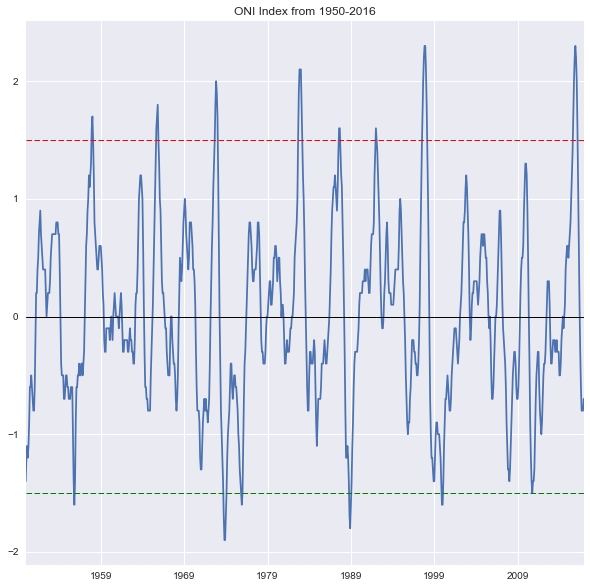

In [166]:
#Plot ONI Index over time.
oni_series.plot()
plt.axhline(1.5, color='r', linestyle='--', lw=1)
plt.axhline(0, color='black', lw=1)
plt.axhline(-1.5, color='g', linestyle='--', lw=1)
plt.title("ONI Index from 1950-2016")
plt.show()

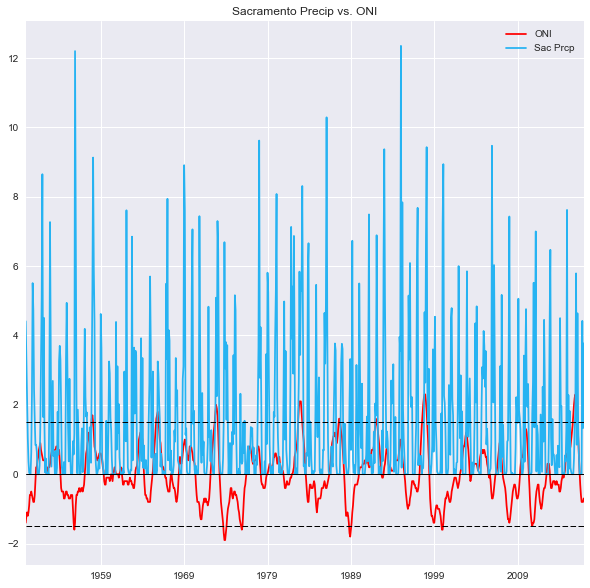

In [167]:
# Sacramento Precip vs. ONI
dates_prcpsac = pd.date_range('1950-01', '2017-01', freq='M')
sac_data = final_df_ONI.loc[final_df_ONI['location'] == "Sacramento, CA"]
sac_prcp = array(sac_data.loc[:,'PRCP'])
sac_prcp_ser = Series(sac_prcp, index=dates_prcpsac)
sac_prcp_oni = DataFrame({'ONI' : oni_series, 'Sac Prcp' : sac_prcp_ser})
sac_prcp_oni.plot(color=['red',(0.15,0.7,0.95)])
plt.axhline(1.5, color='black', linestyle='--', lw=1)
plt.axhline(0, color='black', lw=1)
plt.axhline(-1.5, color='black', linestyle='--', lw=1)
plt.title("Sacramento Precip vs. ONI")

In [168]:
# Dates by month in range [01-1950 - 12-2016]
dates_monthly = pd.date_range('1950-01', '2017-01', freq='M')
dom_cities_list = [domestic_station_ids[idx][1] for idx in range(len(domestic_station_ids))]
split_by_city = [final_df_ONI.loc[final_df_ONI['location'] == dom_city] for dom_city in dom_cities_list] # list comprehension iterating through all cities in dom. list

# loop over all of the lists in split_by_city and plot a line for each on the same plot (interactive)
dates_monthly

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',
               '2016-07-31', '2016-08-31', '2016-09-30', '2016-10-31',
               '2016-11-30', '2016-12-31'],
              dtype='datetime64[ns]', length=804, freq='M')

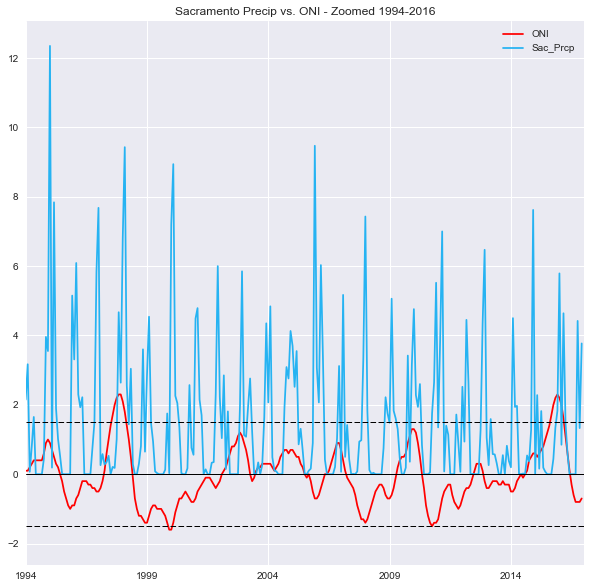

In [169]:
# Sacramento Precip vs. ONI - Zoomed 1994-2016
sac_prcp_oni = DataFrame({'ONI' : oni_series, 'Sac_Prcp' : sac_prcp_ser})
sac_prcp_oni_full = sac_prcp_oni.plot(color=['red',(0.15,0.7,0.95)])
sac_prcp_oni_full.set_xlim(pd.Timestamp('1994-01'), pd.Timestamp('2017-01'))
plt.title("Sacramento Precip vs. ONI - Zoomed 1994-2016")
plt.axhline(1.5, color='black', linestyle='--', lw=1)
plt.axhline(0, color='black', lw=1)
plt.axhline(-1.5, color='black', linestyle='--', lw=1)

/Users/Ricky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10).corr(other=<Series>)


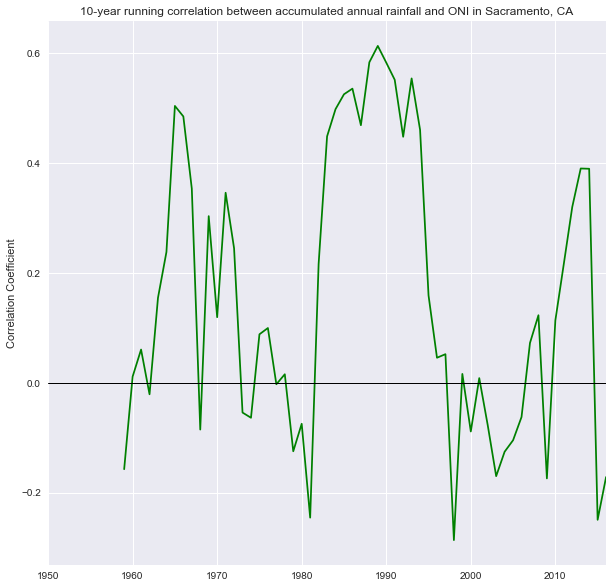

In [170]:
# 10-year running correlation between accumulated annual rainfall and ONI in Sacramento, CA
sac_prcpyear = sac_data.loc[:,['Year','PRCP']]
sac_prcpyear['PRCP'] = pd.to_numeric(sac_prcpyear['PRCP'], errors='coerce')
sac_prcp_accum = sac_prcpyear.groupby("Year").sum()
oni_accum_year = sac_data.loc[:,['Year','ONI']].groupby("Year").mean()

dates_yearly = pd.date_range('1950-01', '2017-01', freq='A')
sac_prcp_ser = Series(array(sac_prcp_accum.loc[:,'PRCP']), index=dates_yearly)
oni_ser = Series(array(oni_accum_year.loc[:,'ONI']), index=dates_yearly)

sac_prcp_oni = DataFrame({'ONI_avg' : oni_ser, 'Sac_Prcp_Total' : sac_prcp_ser})
pd.rolling_corr(sac_prcp_oni.ONI_avg, sac_prcp_oni.Sac_Prcp_Total, window=10).plot(style='-g')
plt.axhline(0, color='black', lw=1)
plt.title("10-year running correlation between accumulated annual rainfall and ONI in Sacramento, CA")
plt.ylabel("Correlation Coefficient")
plt.show()

/Users/Ricky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=36).corr(other=<Series>)


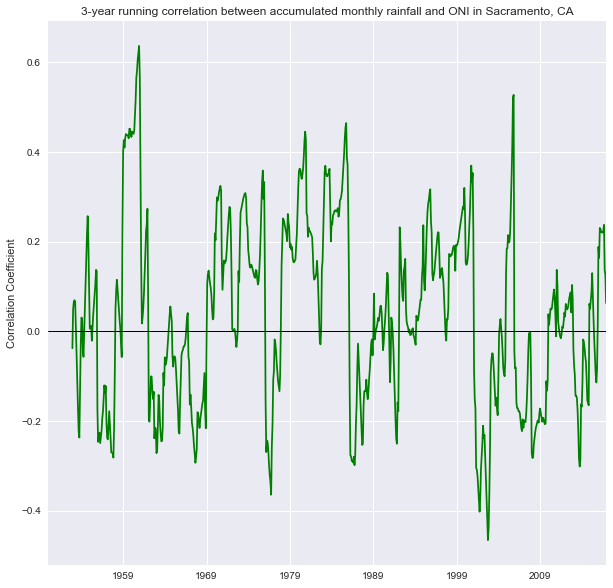

In [171]:
# 3-year running correlation between accumulated monthly rainfall and ONI in Sacramento, CA
sac_prcp_ser = Series(sac_prcp, index=dates_prcpsac)
sac_prcp_oni = DataFrame({'ONI' : oni_series, 'Sac_Prcp' : sac_prcp_ser})
pd.rolling_corr(sac_prcp_oni.ONI, sac_prcp_oni.Sac_Prcp, window=36).plot(style='-g')
plt.axhline(0, color='black', lw=1)
plt.title("3-year running correlation between accumulated monthly rainfall and ONI in Sacramento, CA")
plt.ylabel("Correlation Coefficient")
plt.show()

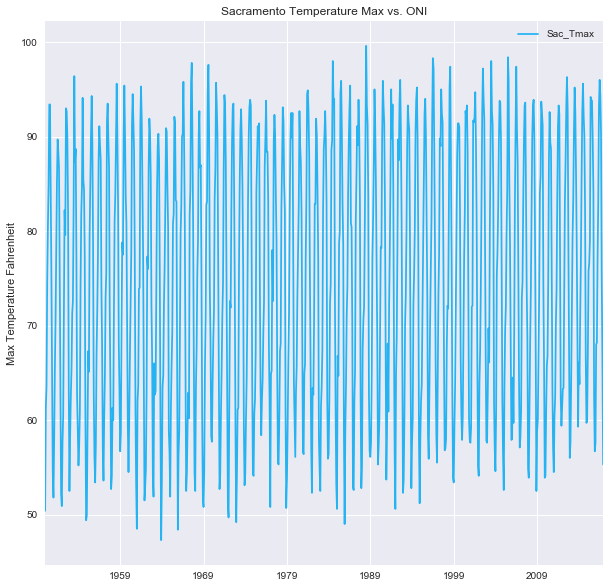

In [172]:
# Sacramento Temperature Max vs. ONI
dates_tempsac = pd.date_range('1950-01', '2017-01', freq='M')
sac_data = final_df_ONI.loc[final_df_ONI['location'] == "Sacramento, CA"]
sac_tmax = array(sac_data.loc[:,'TMAX'])
sac_tmax_ser = Series(sac_tmax, index=dates_tempsac)
sac_tmax_oni = DataFrame({'Sac_Tmax' : sac_tmax_ser})
sac_tmax_oni.plot(color=(0.15,0.7,0.95))
plt.title("Sacramento Temperature Max vs. ONI")
plt.ylabel("Max Temperature Fahrenheit")
plt.show()

/Users/Ricky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=120).corr(other=<Series>)


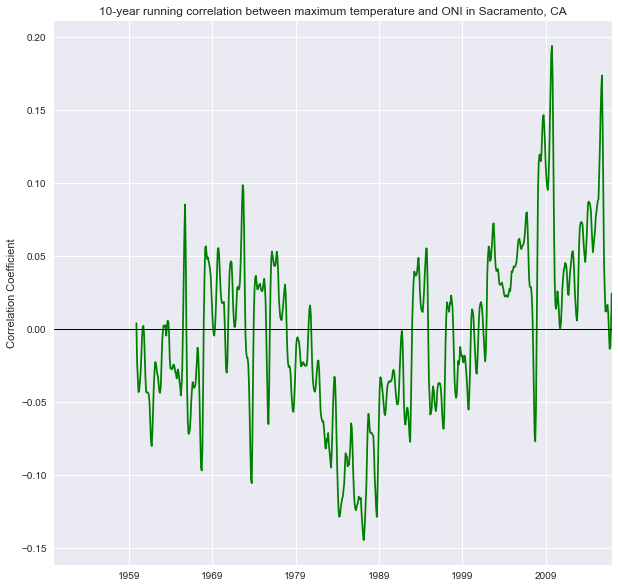

In [173]:
# 10-year running correlation between maximum temperature and ONI in Sacramento, CA
sac_tmax_ser = Series(sac_tmax, index=dates_tempsac)
sac_tmax_oni = DataFrame({'ONI' : oni_series, 'Sac_Tmax' : sac_tmax_ser})
pd.rolling_corr(sac_tmax_oni.ONI, sac_tmax_oni.Sac_Tmax, window=120).plot(style='-g')
plt.axhline(0, color='black', lw=1)
plt.title("10-year running correlation between maximum temperature and ONI in Sacramento, CA")
plt.ylabel("Correlation Coefficient")
plt.show()

<h3>Data Part 3: Extract data from the NOAA storm database through csvs and explore distribution of precipitation related damages in the United States</h3>

In [176]:
url = "https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
storm_req = requests.get(url) #Ping the server
storm_html = storm_req.text #Obtain the text file of the webstie
storm = BeautifulSoup(storm_html, 'lxml') #Change to html code
storm_data = storm.findAll('a')#{'href':str.startswith("StormEvents_details")})

#Obtain all the csv names to download
links = []
for line in storm_data:
    if re.search("StormEvents_details",line.text) != None:
        links.append(str(line.text)[:-3])

In [183]:
cd_path = os.getcwd()+"/Storm Data/CSV" # return path of current directory

#Open each csv and append to by columns to create a dataframe
data_storms = []
for link in links:
    filepath = os.path.join(cd_path, link) # returns path to open fname
    data_storms.append(pd.DataFrame.from_csv(filepath, index_col = None))   

In [184]:
#Create a dataframe with all columns
complete_storm_df = pd.concat(data_storms, ignore_index=True) #Get rid of index values
complete_storm_df['Inj'] = complete_storm_df['INJURIES_DIRECT']+complete_storm_df['INJURIES_INDIRECT'] #Obtain an injuries column
complete_storm_df['Death'] = complete_storm_df['DEATHS_DIRECT']+complete_storm_df['DEATHS_INDIRECT'] #Obtain a deaths column

#Create a dataframe with only the columns of interest to cut down on computational intensity
interest_df = (complete_storm_df[['BEGIN_YEARMONTH', 'STATE', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE','CZ_NAME','Inj','Death','DAMAGE_PROPERTY','DAMAGE_CROPS','BEGIN_LAT','BEGIN_LON']].copy())
interest_df.rename(columns={'BEGIN_YEARMONTH': 'Date', 'STATE': 'State', 'MONTH_NAME': 'Month', 'EVENT_TYPE': 'Event', 'CZ_NAME': 'City', 'MONTH_NAME': 'Month', 'DAMAGE_PROPERTY': 'Prop_Dmg', 'DAMAGE_CROPS': 'Crop_Dmg', 'YEAR':'Year','BEGIN_LAT':'Lat', 'BEGIN_LON':'Lon'}, inplace=True)
interest_df = interest_df.dropna()

#Change the date column into the right format. Do not care about the individual day since data for whole project is monthly. Looking at general trends.
dates=[]
for x in interest_df["Date"]:
    date = str(x)[:4]+'-'+str(x)[4:]
    dates.append(date)
interest_df["Date"] = dates

#Change the month column from a string to a number
month_num = []
for x in interest_df["Date"]:
    num = x.split("-")[1]
    month_num.append(num)
interest_df["Month"] = month_num

In [185]:
#This function changes the letters used to abbreviate numbers and returns the corresponding value as a float.
def change_nums_float(column):
    """
    Input: Takes in a column of a database/list as a string
    Output: Returns a list as a float
    """
    
    prop = []
    for row_int in column: #Loop over every element in the row/dataframe
        try: #Attempt to switch the string to a float of the corresponding amount.
            row = str(row_int) # convert to string so use the search function
            
            if re.search("K", row, re.IGNORECASE):
                if re.search("K", row[0], re.IGNORECASE):
                    prop.append(1000)
                else:
                    prop.append(float(row[:-1])*1000)
            
            elif re.search("H", row, re.IGNORECASE):
                prop.append(float(row[:-1])*100)
            
            elif re.search("M", row, re.IGNORECASE):
                if re.search("M", row[0], re.IGNORECASE):
                    prop.append(1000000)
                else:
                    prop.append(float(row[:-1])*1000000)
                
            elif re.search("B", row, re.IGNORECASE):
                prop.append(float(row[:-1])*1000000000) 
                
            elif re.search("T", row, re.IGNORECASE):
                prop.append(float('nan'))
            
            elif re.search("0", row[0], re.IGNORECASE):
                prop.append(float(0))    
            
            else:
                prop.append(float(row))    
    
        except: #If the above fails convert the value to nan.
            prop.append(float('nan'))
    
    return prop

In [186]:
interest_df["Prop_Dmg"] = change_nums_float(interest_df["Prop_Dmg"]) #Change all the property damage values to a float.
interest_df["Crop_Dmg"] = change_nums_float(interest_df["Crop_Dmg"]) #Change all the crop damage values to a float.
interest_df = interest_df.dropna()

In [187]:
def set_na(column):
    """
    Input: Take in a list containing strings 
    Output: Return a list containing strings
    
    Set all values in a column that are the string nan to a float equal to the value of nan.
    """
    
    values = []
    for name in column:
        name_string = str(name)
        if re.search("nan", name_string, re.IGNORECASE):
            values.append(float('NaN'))
        else:
            values.append(name_string)
    return values

In [188]:
interest_df["State"] = set_na(interest_df["State"]) #Change all the string nan values to a float nan value
interest_df["City"] = set_na(interest_df["City"]) #Change all the string nan values to a float nan value
interest_df = interest_df.dropna()

In [189]:
def lower_case_all_but_first_letter(column):
    """
    Input: Take in a list containing strings 
    Output: Return a list containing strings
    
    Purpose: Undercase a word except for the first letter.
    """
    city_list = []
    for name in column:
        city_lower = name[0] + name[1:].lower()
        city_list.append(city_lower)
    return city_list

In [190]:
interest_df["State"] = lower_case_all_but_first_letter(interest_df["State"]) #Change the city name to be lower case except for the first letter
interest_df["City"] = lower_case_all_but_first_letter(interest_df["City"]) #Change the city name to be lower case except for the first letter

In [191]:
#Dictionary of US State abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New hampshire': 'NH',
    'New jersey': 'NJ',
    'New mexico': 'NM',
    'New york': 'NY',
    'North carolina': 'NC',
    'North dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode island': 'RI',
    'South carolina': 'SC',
    'South dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [192]:
#Dictionary of US State regions
us_state_Region = {
    'Alabama': 'South East',
    'Alaska': 'Pacific',
    'Arizona': 'West',
    'Arkansas': 'South East',
    'California': 'Pacific',
    'Colorado': 'West',
    'Connecticut': 'North East',
    'Delaware': 'North East',
    'Florida': 'South East',
    'Georgia': 'South East',
    'Hawaii': 'Pacific',
    'Idaho': 'West',
    'Illinois': 'Central',
    'Indiana': 'Central',
    'Iowa': 'Central',
    'Kansas': 'Central',
    'Kentucky': 'South East',
    'Louisiana': 'South East',
    'Maine': 'North East',
    'Maryland': 'North East',
    'Massachusetts': 'North East',
    'Michigan': 'Central',
    'Minnesota': 'Central',
    'Mississippi': 'South East',
    'Missouri': 'Central',
    'Montana': 'West',
    'Nebraska': 'Central',
    'Nevada': 'West',
    'New hampshire': 'North East',
    'New jersey': 'North East',
    'New mexico': 'West',
    'New york': 'North East',
    'North carolina': 'South East',
    'North dakota': 'Central',
    'Ohio': 'Central',
    'Oklahoma': 'Central',
    'Oregon': 'Pacific',
    'Pennsylvania': 'North East',
    'Rhode island': 'North East',
    'South carolina': 'South East',
    'South dakota': 'Central',
    'Tennessee': 'South East',
    'Texas': 'Central',
    'Utah': 'West',
    'Vermont': 'North East',
    'Virginia': 'South East',
    'Washington': 'Pacific',
    'West virginia': 'Central',
    'Wisconsin': 'Central',
    'Wyoming': 'Central',
}

In [193]:
#Put the state abbreviations on to the end of the main data frame
state_abbreviations = []
for state in interest_df["State"]:
    try:
        State_abb = us_state_abbrev[state]
        state_abbreviations.append(State_abb)
    except:
        state_abbreviations.append(float('NaN'))
interest_df["State Abb"] = state_abbreviations
interest_df = interest_df.dropna()
interest_df = interest_df.reset_index(drop=True)

In [194]:
#Change the city to follow the same format as the Web API to allow comparrisons between that dataset and this dataset.
updated_complete = []
for line in range(len(interest_df["City"])):
    updated = interest_df["City"][line]+", "+interest_df["State Abb"][line]
    updated_complete.append(updated)
interest_df["City"] = updated_complete

In [195]:
#Add regions to the main data frame to allow for subsetting by specific regions
state_regions = []
for state in interest_df["State"]:
    try:
        State_reg = us_state_Region[state]
        state_regions.append(State_reg)
    except:
        state_regions.append(float('NaN'))
interest_df["Regions"] = state_regions

In [196]:
interest_df.head()

,Date,State,Year,Month,Event,City,Inj,Death,Prop_Dmg,Crop_Dmg,Lat,Lon,State Abb,Regions
0,1950-04,Oklahoma,1950,04,Tornado,"Washita, OK",0,0,250000.0,0.0,35.12,-99.20,OK,Central
1,1950-04,Texas,1950,04,Tornado,"Comanche, TX",0,0,25000.0,0.0,31.90,-98.60,TX,Central
2,1950-07,Pennsylvania,1950,07,Tornado,"Lehigh, PA",2,0,25000.0,0.0,40.58,-75.70,PA,North East
3,1950-07,Pennsylvania,1950,07,Tornado,"Dauphin, PA",0,0,2500.0,0.0,40.60,-76.75,PA,North East
4,1950-07,Pennsylvania,1950,07,Tornado,"Crawford, PA",0,0,2500.0,0.0,41.63,-79.68,PA,North East


<h4>Use SQL to quickly examine the database</h4>

In [198]:
#Change DataFrame to SQL Database for ease of use querying
engine = create_engine('sqlite:///:memory:')
interest_df.to_sql('storm_data', engine)

In [199]:
#Look at the sql database
storm_sql = pd.read_sql_table('storm_data', engine, index_col = "index")
storm_sql.head()

,Date,State,Year,Month,Event,City,Inj,Death,Prop_Dmg,Crop_Dmg,Lat,Lon,State Abb,Regions
index,,,,,,,,,,,,,,
0,1950-04,Oklahoma,1950,04,Tornado,"Washita, OK",0,0,250000.0,0.0,35.12,-99.20,OK,Central
1,1950-04,Texas,1950,04,Tornado,"Comanche, TX",0,0,25000.0,0.0,31.90,-98.60,TX,Central
2,1950-07,Pennsylvania,1950,07,Tornado,"Lehigh, PA",2,0,25000.0,0.0,40.58,-75.70,PA,North East
3,1950-07,Pennsylvania,1950,07,Tornado,"Dauphin, PA",0,0,2500.0,0.0,40.60,-76.75,PA,North East
4,1950-07,Pennsylvania,1950,07,Tornado,"Crawford, PA",0,0,2500.0,0.0,41.63,-79.68,PA,North East


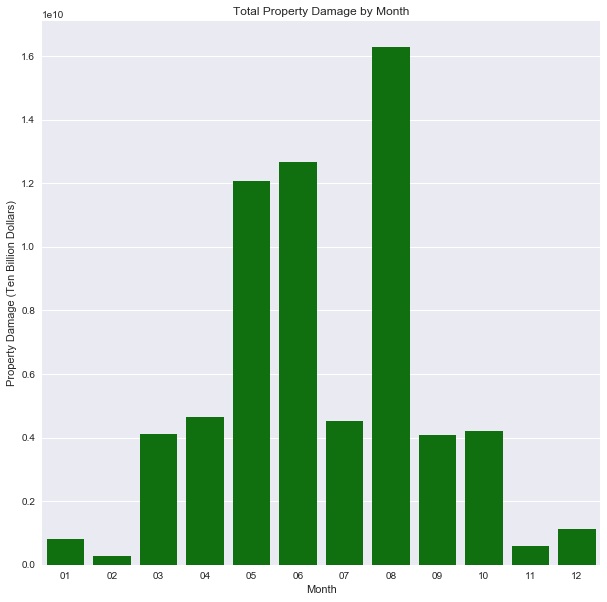

In [200]:
#Obtain the query and plot that looks at each month and acquires the total damages in that month for all years combined.
Month_dmg = pd.read_sql_query('SELECT Month, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning" \
                    GROUP BY Month', engine)
sns.barplot(x=Month_dmg['Month'], y=Month_dmg["Total Dmg"],color="green")
plt.title("Total Property Damage by Month")
plt.ylabel("Property Damage (Ten Billion Dollars)")
plt.show()

In [201]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
Pacific_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "Pacific" OR Regions == "West") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

In [202]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
Central_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "Central") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

In [203]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
SE_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "South East") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

In [204]:
#Reports prior to 1990 are sparse so only take after 1990. Look at events that could be cause by rain. Break apart by region.
NE_dmg = pd.read_sql_query('SELECT Year, SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total Dmg" FROM storm_data \
                    WHERE (Regions == "North East") AND (YEAR >=1990) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Year', engine)

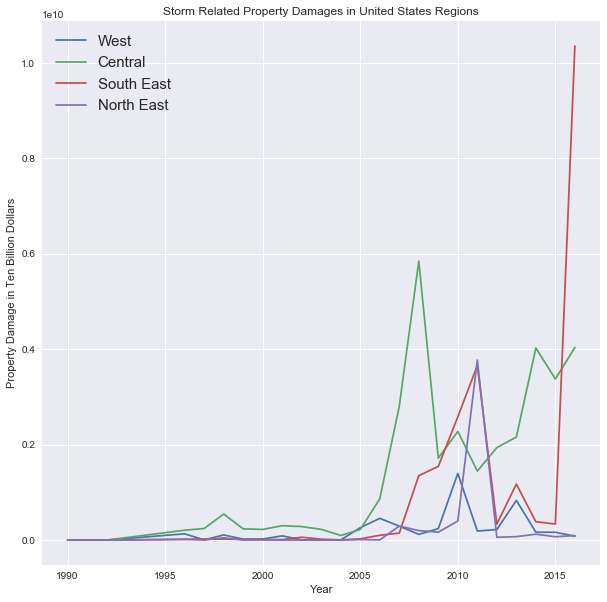

In [205]:
#Graph the 4 regions against eachother with total damage on the y and year on the x.
sns.set_style("darkgrid")
plt.plot(Pacific_dmg["Year"], Pacific_dmg["Total Dmg"])
plt.plot(Central_dmg["Year"], Central_dmg["Total Dmg"])
plt.plot(SE_dmg["Year"], SE_dmg["Total Dmg"])
plt.plot(NE_dmg["Year"], NE_dmg["Total Dmg"])

plt.title("Storm Related Property Damages in United States Regions")
plt.xlabel("Year")
plt.ylabel("Property Damage in Ten Billion Dollars")
plt.legend(('West', 'Central', 'South East', 'North East'),
           loc='upper left',
           fontsize=15)
plt.show()

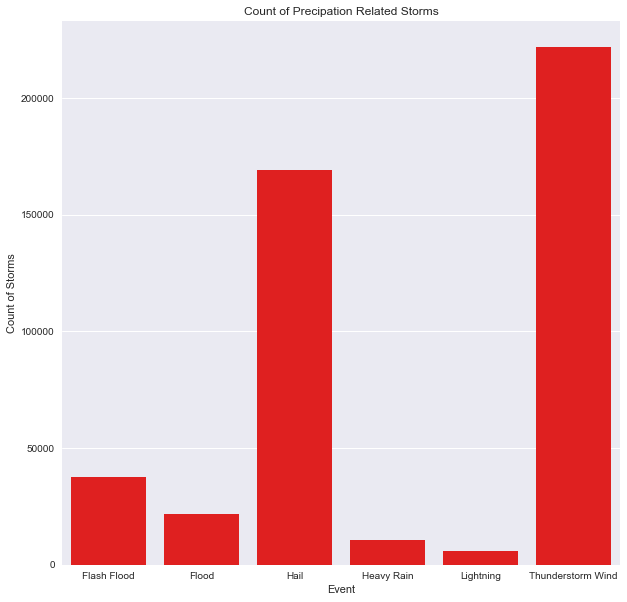

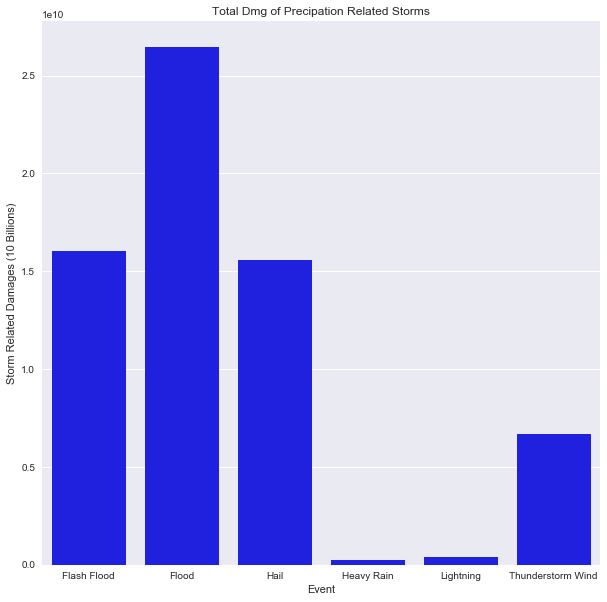

In [206]:
#Look at counts for type of events that caused damages that could be caused by rain.
all_rain_storms = pd.read_sql_query('SELECT Event, Count(Event), SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total_Dmg" FROM storm_data \
                    WHERE (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                    GROUP BY Event', engine)

#Bar plot of counts
sns.barplot(x=all_rain_storms['Event'], y=all_rain_storms["Count(Event)"],color="red")
plt.title("Count of Precipation Related Storms")
plt.ylabel("Count of Storms")
plt.show()

#Bar plot for amount of total damages that type of storm caused.
sns.barplot(x=all_rain_storms['Event'], y=all_rain_storms["Total_Dmg"],color="blue")
plt.title("Total Dmg of Precipation Related Storms")
plt.ylabel("Storm Related Damages (10 Billions)")
plt.show()

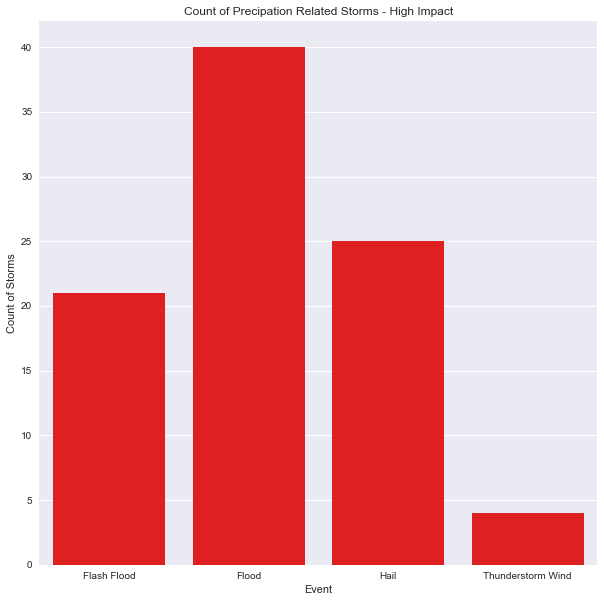

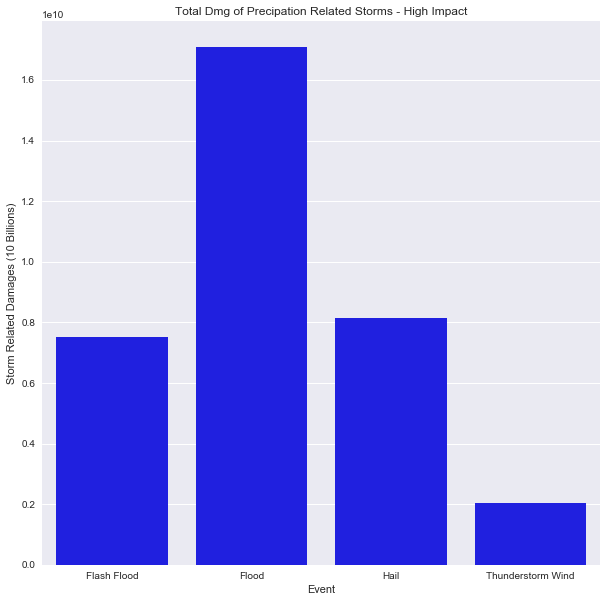

In [208]:
#Look at events that caused over a hundred million dollars worth of damages to get a better idea of what is causing the large losses.
High_impact_storm = pd.read_sql_query('SELECT Event, Count(Event), SUM(Prop_Dmg) + SUM(Crop_Dmg) AS "Total_Dmg" FROM storm_data \
                  WHERE (Prop_Dmg + Crop_DMG > 100000000) AND (Event == "Hail" OR Event == "Thunderstorm Wind" OR Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain" or Event == "Lightning") \
                  GROUP BY Event', engine)

#Bar plot of counts
sns.barplot(x=High_impact_storm['Event'], y=High_impact_storm["Count(Event)"],color="red")
plt.title("Count of Precipation Related Storms - High Impact")
plt.ylabel("Count of Storms")
plt.show()

#Bar plot of total damages
sns.barplot(x=High_impact_storm['Event'], y=High_impact_storm["Total_Dmg"],color="blue")
plt.title("Total Dmg of Precipation Related Storms - High Impact")
plt.ylabel("Storm Related Damages (10 Billions)")
plt.show()

#At over 100 million worth of damages the count becomes proportional to the total damages caused. Floods the most common by far.

In [209]:
#Want to narrow down events to those that were most consistent with large amount of precipitation (i.e. floods, flash flood, and heavy rain). Don't include hail since hail is different than rain and also hail clusters in certain areas of the map making the map hard to read. Start at total damages over 10000 to include all values that cause at least a minor amount of damages.
High_impact_rain_related_dmgs = pd.read_sql_query('SELECT * FROM storm_data \
    WHERE (Prop_Dmg + Crop_DMG >= 10000) AND (Event == "Flood" OR Event == "Flash Flood" or Event == "Heavy Rain")', engine)

/Users/Ricky/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/Ricky/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/Ricky/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


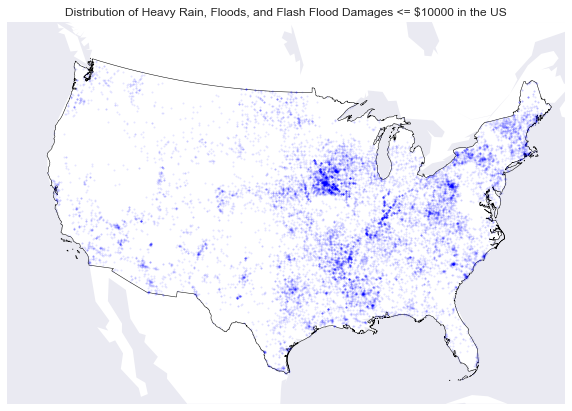

In [210]:
#Use base map to plot all the lon and lat of all the events listed above.
us_map = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=51, projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
us_map.readshapefile("/Users/Ricky/Desktop/cb_2015_us_nation_5m/cb_2015_us_nation_5m", "cb_2015_us_nation_5m")
us_map.fillcontinents(color="white")

for lon, lat in zip(High_impact_rain_related_dmgs.Lon, High_impact_rain_related_dmgs.Lat):
    x, y = us_map(lon, lat)  
    us_map.plot(x, y, 'b' + 'o', markersize = 2, alpha=.1)

plt.title("Distribution of Heavy Rain, Floods, and Flash Flood Damages <= $10000 in the US")
plt.show()

We tried closing the SQL database but due to the way that we transferred the pd dataframe to the SQL database we could not figure out how to close the session. We tried using engine.close() but Google told me that the engine is a tool used by SQL to act as an enabler for SQL and so that you don't close that. We then tried closing the storm_data, but that got an error message. Lastly, we tried closing the storm_sql, but that is a dataframe so that wouldn't close. Nothing we looked up on google matched what I had and since what we have works we did not want to try to transform my code to something on stackoverflow that we was not sure if it would work.